###  Дмитрий МАРЬИН   group dspr-48  
#### Юнит 4. Работа с базами данных. SQL - Проект 4. Авиарейсы без потерь (**RDS_05**)  
____

### 1. Получение параметров (ключей) для  последующего основного запроса

### 2. Основной запрос  
**ID рейса, дата, тип ВС, куда, продолжительность, выручка, число паксов, число мест, % заполнения**

### 3. Дополнительный запрос  - с разбивкой по тарифам (классам)
ID рейса, дата, тип ВС, куда, продолжительность, выручка, число паксов, число мест, % заполнения **+ класс**

Справочные данные для оценки прибыльности из интернета
[стоимость топлива](https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm?id=7329)  
**Топливо** - стоимость на 15 января 2017 в Анапе  = **41435 руб за тонну**  
[Расход топлива по типам](
https://vpolete.online/pereletyi/rashod-topliva-raznyih-samoletov.html#i-2)  
Минутный **расход** Sukhoi Superjet 100: **1,7/60 т/мин**, Boeing 737-300: **2,4/60 т/мин**

### Работаем с файлом - **avia.csv**  
(без разбивки на классы салона)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('avia.csv')
df.columns = ['flight', 'date', 'code', 'port',
              'duration', 'sales', 'pax', 'capacity', 'fill_rate']
df['date'] = df['date'].str.slice(stop=10)  # remove time from string
df['date'] = pd.to_datetime(df['date'])  # convert string to date format
df['fill_rate'] = df['fill_rate'].round(1)  # 'fill_rate' - уровень заполнения салона

In [3]:
def my_function(my_col):  
    if my_col == '733':
        return 2.4/60   # минутный расход Boeing
    elif my_col == 'SU9':
        return 1.7/60   # минутный расход Sukhoi
df['fuel_rate'] = df.apply(lambda x: my_function(x['code']), axis=1)

fuel_price = 41435  # цена в рублях за тонну на янв 2017 из интернета
df['fuel_cost'] = df['fuel_rate'] * fuel_price  # считаем расходы на топливо
df['fuel_cost'] =df['fuel_cost'].round()

In [4]:
df['profit'] = (df['sales'] - df['fuel_cost']) # прибыль = выручка - расходы на топливо
df['fuel_cost'] =df['fuel_cost'].round()

In [5]:
df.sample(4)

,flight,date,code,port,duration,sales,pax,capacity,fill_rate,fuel_rate,fuel_cost,profit
172,136929,2016-12-31,SU9,EGO,50.0,631800.0,82,97,84.5,0.028333,1174.0,630626.0
96,136612,2017-02-21,SU9,EGO,50.0,746400.0,94,97,96.9,0.028333,1174.0,745226.0
47,136318,2016-12-17,733,SVO,100.0,1544400.0,104,130,80.0,0.040000,1657.0,1542743.0
174,136937,2017-01-03,SU9,EGO,50.0,626100.0,81,97,83.5,0.028333,1174.0,624926.0


### 1. Оценка по уровеню заполнения салона ('fill_rate')

<AxesSubplot:xlabel='fill_rate', ylabel='Count'>

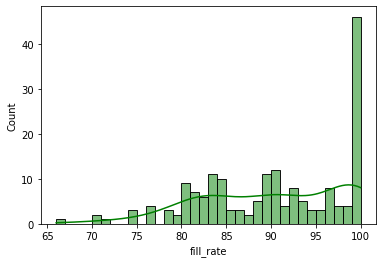

In [6]:
sns.histplot(data=df.fill_rate, bins=50, binwidth=1,
             kde=True, color='green', log_scale=False) # число рейсов по заполняемости

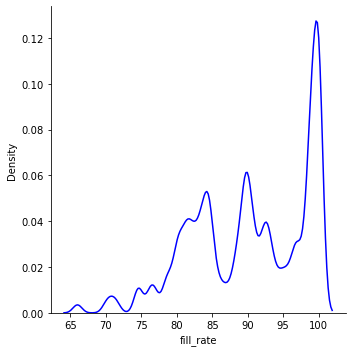

In [7]:
sns.displot(df, x="fill_rate", kind="kde", 
            color='blue', bw_adjust=.22) # число рейсов по заполняемости

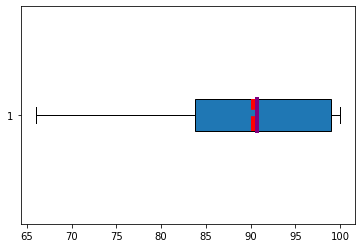

In [8]:
fig, ax = plt.subplots()
ax.boxplot(df.fill_rate, vert=False, showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 4, 'color': 'purple'},
           meanprops={'linewidth': 4, 'color': 'red'})
plt.show() # часть рейсов выделяется из общей массы - убыточные "хвосты"

Оценим число рейсов с **заполняемостью ниже 75%**

In [9]:
display(df[df.fill_rate < 75].sort_values(['fill_rate'], ascending=True))

,flight,date,code,port,duration,sales,pax,capacity,fill_rate,fuel_rate,fuel_cost,profit
102,136642,2017-01-30,SU9,EGO,50.0,531000.0,64,97,66.0,0.028333,1174.0,529826.0
144,136807,2017-02-23,SU9,EGO,50.0,531000.0,68,97,70.1,0.028333,1174.0,529826.0
56,136352,2016-12-10,733,SVO,100.0,1372400.0,92,130,70.8,0.040000,1657.0,1370743.0
30,136253,2016-12-24,733,SVO,100.0,1407800.0,93,130,71.5,0.040000,1657.0,1406143.0
2,136122,2017-01-08,733,SVO,100.0,1431000.0,97,130,74.6,0.040000,1657.0,1429343.0
57,136360,2017-02-05,733,SVO,100.0,1455400.0,97,130,74.6,0.040000,1657.0,1453743.0
69,136418,2016-12-07,733,SVO,100.0,1407800.0,97,130,74.6,0.040000,1657.0,1406143.0


### 2. Оценка  по "прибыли" ('profit')
Прибыль считается как **разница между выручкой от продажи билетов и расходами на топливо**

<AxesSubplot:xlabel='profit', ylabel='Count'>

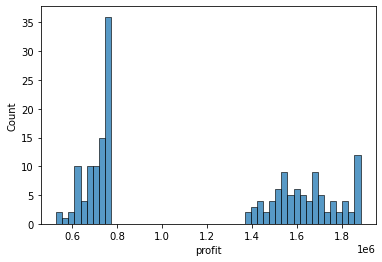

In [10]:
sns.histplot(data=df.profit, bins=50,)

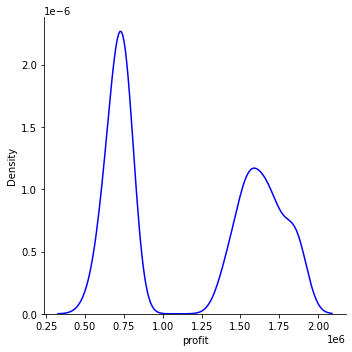

In [11]:
sns.displot(df, x="profit", kind="kde", 
            color='blue', bw_adjust=.4) # число рейсов по заполняемости

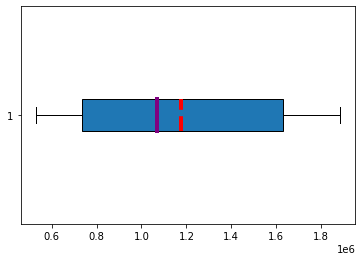

In [12]:
fig, ax = plt.subplots()
ax.boxplot(df.profit, vert=False, showmeans=True, meanline=True,
           patch_artist=True,
           medianprops={'linewidth': 4, 'color': 'purple'},
           meanprops={'linewidth': 4, 'color': 'red'})
plt.show() # часть рейсов выделяется из общей массы - убыточные "хвосты"

Оценим число рейсов с **прибылью меньше 620,000 руб**

In [13]:
display(df[df.profit < 620000].sort_values(['profit'], ascending=True))

,flight,date,code,port,duration,sales,pax,capacity,fill_rate,fuel_rate,fuel_cost,profit
102,136642,2017-01-30,SU9,EGO,50.0,531000.0,64,97,66.0,0.028333,1174.0,529826.0
144,136807,2017-02-23,SU9,EGO,50.0,531000.0,68,97,70.1,0.028333,1174.0,529826.0
152,136844,2017-02-28,SU9,EGO,50.0,575100.0,79,97,81.4,0.028333,1174.0,573926.0
164,136887,2017-01-20,SU9,EGO,50.0,595200.0,78,97,80.4,0.028333,1174.0,594026.0
170,136922,2017-02-11,SU9,EGO,50.0,607800.0,76,97,78.4,0.028333,1174.0,606626.0
98,136620,2017-02-17,SU9,EGO,50.0,613500.0,79,97,81.4,0.028333,1174.0,612326.0
147,136823,2017-02-05,SU9,EGO,50.0,620400.0,78,97,80.4,0.028333,1174.0,619226.0


### Выберем два худших рейса по заполняемости и по прибыли  
это одни те же рейсы SU9 в Белгород - **136642 и 136807** (30 января и 23 февраля 2017)

In [14]:
display(df.nsmallest(2, 'fill_rate'))

,flight,date,code,port,duration,sales,pax,capacity,fill_rate,fuel_rate,fuel_cost,profit
102,136642,2017-01-30,SU9,EGO,50.0,531000.0,64,97,66.0,0.028333,1174.0,529826.0
144,136807,2017-02-23,SU9,EGO,50.0,531000.0,68,97,70.1,0.028333,1174.0,529826.0


In [15]:
display(df.nsmallest(2, 'profit'))

,flight,date,code,port,duration,sales,pax,capacity,fill_rate,fuel_rate,fuel_cost,profit
102,136642,2017-01-30,SU9,EGO,50.0,531000.0,64,97,66.0,0.028333,1174.0,529826.0
144,136807,2017-02-23,SU9,EGO,50.0,531000.0,68,97,70.1,0.028333,1174.0,529826.0


<AxesSubplot:xlabel='fill_rate', ylabel='profit'>

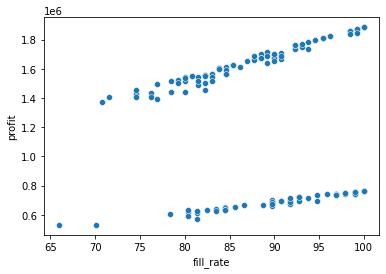

In [16]:
sns.scatterplot(data=df, x="fill_rate", y="profit") # две крайние левые точки на диаграмме

### Вывод - в зимнее время самыми малоприбыльными рейсами являются
### рейсы с flight_ID 136642 и 136807

______

**Дополнительно** можно провести анализ по тарифным классам (**Buseness и Economy**)  
______

In [17]:
df2 = pd.read_csv('aviaclass.csv')
df2.columns = ['flight', 'date', 'code', 'port',
              'duration', 'class', 'sales', 'pax', 'capacity', 'fill_rate']
df2['date'] = df2['date'].str.slice(stop=10)  # remove time from string
df2['date'] = pd.to_datetime(df2['date'])  # convert string to date format
df2['fill_rate'] = df2['fill_rate'].round(1)  # 'fill_rate' - уровень заполнения салона

In [18]:
def my_function(my_col):  
    if my_col == '733':
        return 2.4/60   # минутный расход Boeing
    elif my_col == 'SU9':
        return 1.7/60   # минутный расход Sukhoi
df2['fuel_rate'] = df.apply(lambda x: my_function(x['code']), axis=1)

fuel_price = 41435  # цена в рублях за тонну на янв 2017 из интернета
df2['fuel_cost'] = df2['fuel_rate'] * fuel_price  # считаем расходы на топливо
df2['fuel_cost'] =df2['fuel_cost'].round()

In [19]:
df2['profit'] = (df2['sales'] - df2['fuel_cost']) # прибыль = выручка - расходы на топливо
df2['fuel_cost'] =df2['fuel_cost'].round()

In [20]:
df2.sample(4)

,flight,date,code,port,duration,class,sales,pax,capacity,fill_rate,fuel_rate,fuel_cost,profit
217,136661,2017-01-01,SU9,EGO,50.0,Economy,532200.0,84,85,98.8,NaN,NaN,NaN
66,136264,2017-02-18,733,SVO,100.0,Business,402600.0,11,12,91.7,0.040000,1657.0,400943.0
130,136391,2016-12-03,733,SVO,100.0,Business,366000.0,10,12,83.3,0.028333,1174.0,364826.0
332,136900,2017-02-01,SU9,EGO,50.0,Business,226800.0,12,12,100.0,NaN,NaN,NaN


<AxesSubplot:xlabel='fill_rate', ylabel='Count'>

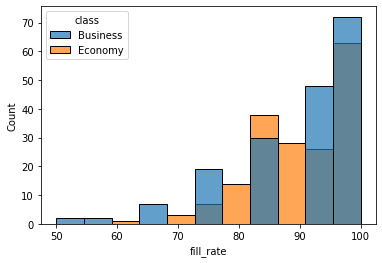

In [21]:
sns.histplot(data = df2
            ,x = 'fill_rate'
            ,alpha = .7
            ,hue = 'class'
            )

<AxesSubplot:xlabel='fill_rate', ylabel='profit'>

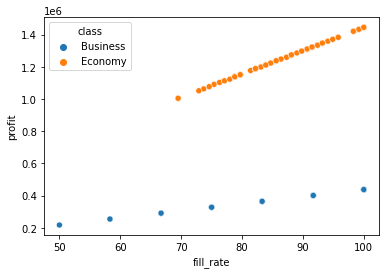

In [22]:
sns.scatterplot(data=df2, x="fill_rate", y="profit"
               ,hue = 'class')  # уровни прибыли и заполняемости